In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.patches import Path, PathPatch
import time
import CustomKernels, CustomModels
from sklearn.model_selection import train_test_split


##Formatting functions
def format_for_learning(xlat, xlon, temp):
    X = np.column_stack((xlat, xlon))
    Y = np.asarray(temp).reshape(len(temp),1)
    return X, Y

def format_grid_for_prediction(ylat, ylon):
    grid = np.column_stack((np.hstack((ylat)),np.hstack((ylon))))
    return grid
    
def format_prediction_to_grid(prediction, nrow, ncol):
    matrix = np.reshape(prediction, (nrow,ncol))  
    return matrix

In [2]:
##Read cities list
obs = pd.read_csv("data/current-version/Temp-2019_01_04-15_47.csv", ',')
obs = obs.drop(['Unnamed: 0'], axis=1)

##Get cities coordinates and ID
nam = obs['City'].tolist()
lon = obs['Lon'].tolist()
lat = obs['Lat'].tolist()
ids = obs['ID'].tolist()
temps = obs['Temp'].tolist()

In [3]:
##Map boundaries
lon_min = -15.56
lat_min = 24.65
lon_max = 49.88
lat_max = 79.17

##Create map
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)

##Interpolation resolution
nx = 100
ny = 100

glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)

##Format data for interpolation
X_learn, y_learn = format_for_learning(lat, lon, temps)
grid = format_grid_for_prediction(glats, glons)

##Partition data between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=0.2)
print("Number of train samples: " + str(X_train.shape[0]))
print("Number of test samples: " + str(X_test.shape[0]))

tic = time.time()

##Choose the interpolation model

#model = CustomModels.NearestNeighbor()
model = CustomModels.InverseDistanceWeighting(radius = 10)
#model = CustomModels.GaussianProcess()
#model = CustomModels.GeographicallyWeightedRegressor()
#model = CustomModels.RegressionTree()
#model = CustomModels.RandomForest()
#model = CustomModels.ExtraTrees()
#model = CustomModels.SupportVectorRegression()
#model = CustomModels.RegressionSplines()

#score_train = model.train(X_train, y_train, eval_score=True)
#print("Train MSE score: " + str(score_train))
#preds, score_test = model.predict(X_test, y_test, eval_score=True)
#print("Test MSE score: " + str(score_test))
#preds = model.predict(grid)
bestc, bests, c, s = model.optimize(X_train, y_train, radius=[10, 100, 200, 400, 500, 600, 1000])
print(str(c))
print(str(s))
print(str(bestc))
print(str(bests))
print("Train MSE score: " + str(bests))
model.set_params(**bestc)
preds, score_test = model.predict(X_test, y_test, eval_score=True)
print("Test MSE score: " + str(score_test))
preds = model.predict(grid)


#model_list = [
#    CustomModels.NearestNeighbor(),
#    CustomModels.InverseDistanceWeighting(),
#    CustomModels.GaussianProcess(),
#    CustomModels.GeographicallyWeightedRegressor(),
#    CustomModels.RegressionTree(),
#    CustomModels.RandomForest(),
#    CustomModels.ExtraTrees(),
#    CustomModels.SupportVectorRegression()
#]
#
#for model in model_list:
#    score_train = model.train(X_train, y_train, eval_score=True)
#    print("Train MSE score: " + str(score_train))
#    preds, score_test = model.predict(X_test, y_test, eval_score=True)
#    print("Test MSE score: " + str(score_test))
#    preds = model.predict(grid)

toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

##Format the predictions for plotting
predict = format_prediction_to_grid(preds, nx, ny)


Number of train samples: 754
Number of test samples: 189
[{'radius': 10}, {'radius': 100}, {'radius': 200}, {'radius': 400}, {'radius': 500}, {'radius': 600}, {'radius': 1000}]
[{'radius': 10}, {'radius': 100}, {'radius': 200}, {'radius': 400}, {'radius': 500}, {'radius': 600}, {'radius': 1000}]
[[ 6.74217934]
 [ 7.28252921]
 [ 4.88612965]
 [ 5.5698566 ]
 [ 5.12759723]
 [ 8.09337292]
 [ 8.15347997]]
{'radius': 200}
4.88612965113
Train MSE score: 4.88612965113
Test MSE score: 6.90793276419
Time: 1336.99989319ms


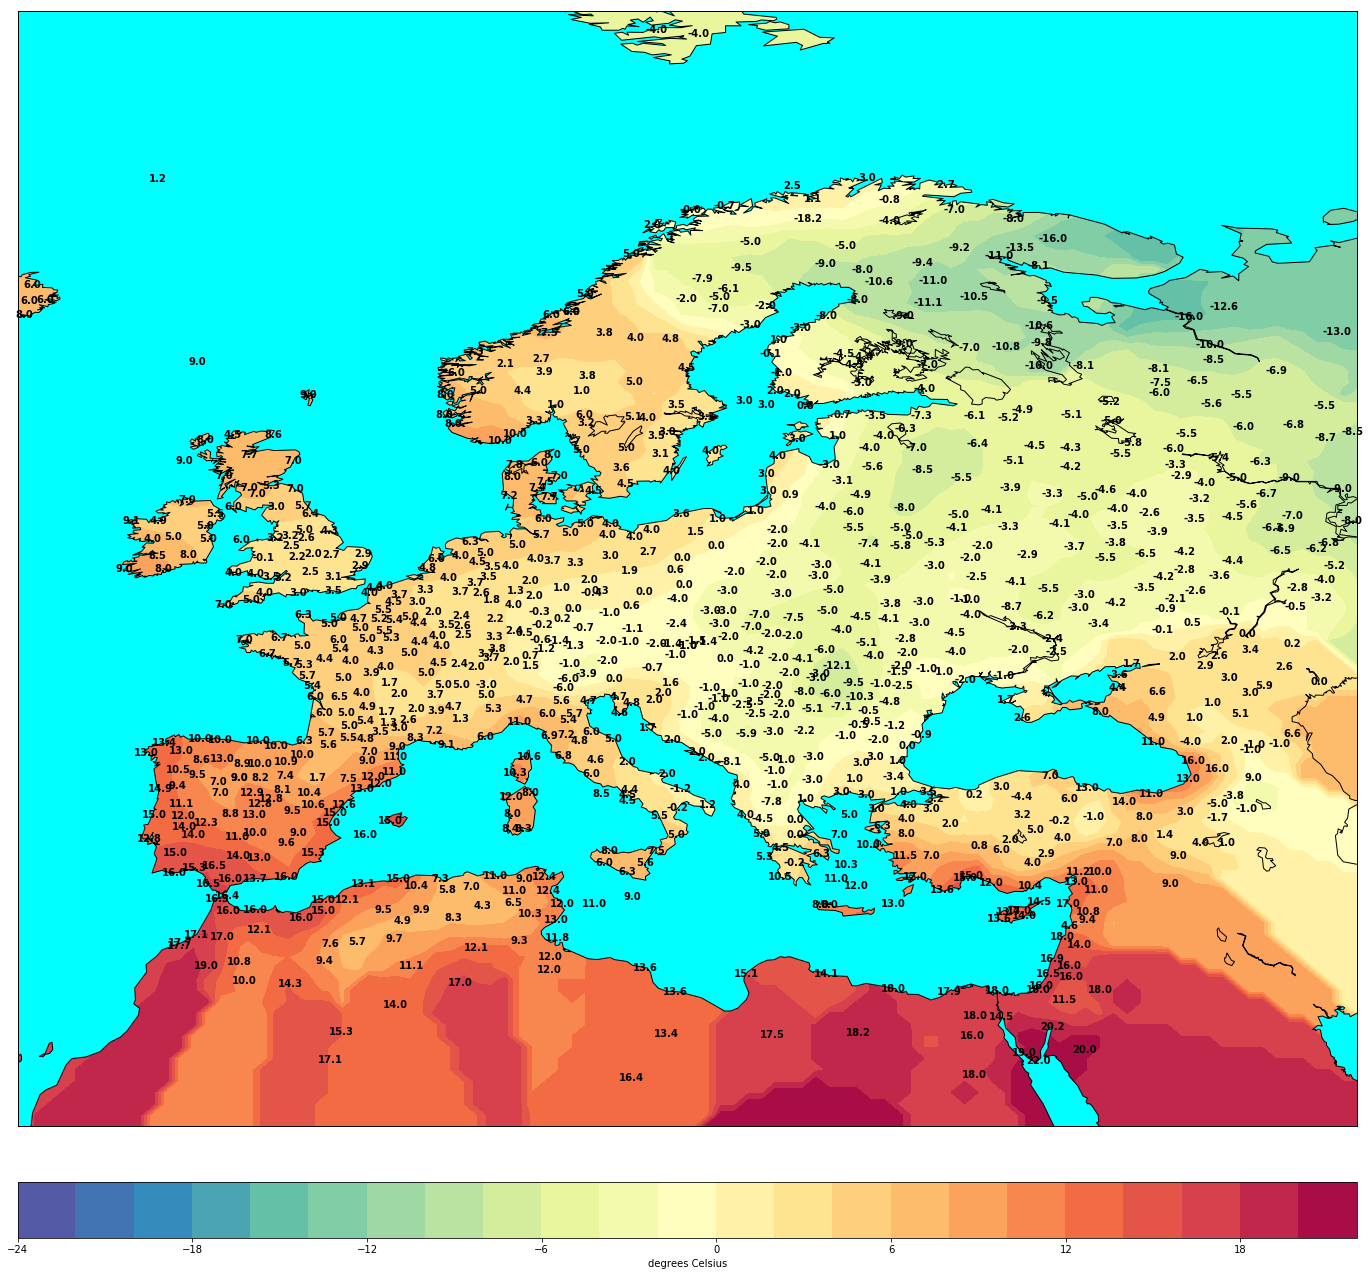

In [4]:
fig, ax = plt.subplots(figsize=(24,24))

map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()

x, y = map(lon, lat)
cities_out_bounds = []

##Create annotations for temperature and only keep cities in bound
for i in range(0,len(x)):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
    else:
        cities_out_bounds.append(nam[i])

##Plot contours
clevs = [-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22]
cs = map.contourf(gx,gy,predict,clevs,cmap='Spectral_r')

##Display colorbar
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')

##Getting the limits of the map:
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##Getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in map.landpolygons]

##Combining with map edges
polys = [map_edges]+polys[:]

##Creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='cyan',lw=0)

##Masking the data:
ax.add_patch(patch)

plt.show()

In [5]:
tic = time.time()
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

Time: 0.0ms


In [6]:
X_train.shape[0]

754L

In [7]:
y_train.shape[0]

754L